# Planejamento de Tarefas com Inteligência Artificial- Trabalho prático
Este projeto utiliza algoritmos para planejamento de tarefas, incluindo o **Critical Path Method (CPM)** e **Algoritmos Genéticos**, aplicados a um problema de gerenciamento de recursos e prazos. 
Desenvolvido por Leandro Leites Ferreira (25997) e Pedro Pinto (25996).
### Objetivos:
1. Carregar e processar dados sobre tarefas, precedência, e recursos.
2. Calcular o *makespan* (tempo total de execução do projeto).
3. Validar a alocação de recursos durante o planejamento.
4. Otimizar a agenda usando Algoritmos Genéticos.
5. Visualizar o plano em um gráfico de Gantt.


## Importação de Bibliotecas
As seguintes bibliotecas são usadas:
- `pandas`: Manipulação de dados.
- `networkx`: Representação e análise do grafo de precedência.
- `matplotlib`: Visualização de gráficos, como o gráfico de Gantt.
- `random`: Operações aleatórias para o algoritmo genético.


In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random


### Carregar Dados
Esta função lê um arquivo de texto estruturado contendo:
1. Relações de precedência entre tarefas.
2. Duração e recursos necessários por tarefa.
3. Recursos disponíveis.

Os dados são processados em três dicionários:
- `predecessores`: Mapeia cada tarefa às suas tarefas predecessoras.
- `duracao_recursos`: Contém a duração e os recursos necessários para cada tarefa.
- `recursos_disponiveis`: Define a quantidade disponível de cada recurso.


In [23]:
def carregar_dados(arquivo):
    with open(arquivo, 'r') as f:
        data = f.readlines()

    predecessores = {}
    duracao_recursos = {}
    recursos_disponiveis = {}

    # Encontrar seções
    for i, line in enumerate(data):
        if line.startswith("#Precedence relations"):
            inicio_precedencia = i + 1
        if line.startswith("#Duration and resources"):
            fim_precedencia = i
            inicio_duracao = i + 1
        if line.startswith("#Resource availability"):
            fim_duracao = i
            inicio_recursos = i + 1

    # Processar Predecessores
    for line in data[inicio_precedencia:fim_precedencia]:
        if line.strip() and not line.startswith('#') and '************************************************************************' not in line:
            partes = list(map(int, line.split()))
            predecessores[partes[0]] = partes[3:]
    
    # Processar Duração e Recursos
    for line in data[inicio_duracao:fim_duracao]:
        if line.strip() and not line.startswith('#') and '************************************************************************' not in line:
            partes = list(map(int, line.split()))
            job_id = partes[0]
            duracao_recursos[job_id] = {
                "duracao": partes[2],
                "recursos": partes[3:]
            }
    
    # Processar Recursos Disponíveis
    for line in data[inicio_recursos:]:
        if line.strip() and not line.startswith('#') and '************************************************************************' not in line:
            partes = line.split()
            recurso = partes[0]
            quantidade = int(partes[1])
            recursos_disponiveis[recurso] = quantidade

    return predecessores, duracao_recursos, recursos_disponiveis


### Cálculo do Makespan

O **makespan** é o tempo total necessário para completar todas as tarefas de um projeto. Este cálculo considera:
1. **Dependências:** Garantir que nenhuma tarefa comece antes da conclusão de suas predecessoras.
2. **Duração:** Somar o tempo necessário para cada tarefa, respeitando as restrições.

#### Passos da Função:
1. **Inicializar tempos:** Define o tempo de início para cada tarefa como `0`.
2. **Iteração pelas tarefas:** Calcula os tempos de início e fim de cada tarefa, considerando suas dependências.
3. **Makespan:** O valor máximo entre os tempos de término de todas as tarefas.

In [24]:
def calcular_makespan(agenda, duracao_recursos):
    tempos_inicio = {tarefa: 0 for tarefa in agenda}
    tempos_fim = {}

    # Inicializa todos os tempos de início com zero, incluindo os dependentes
    for tarefa in agenda:
        if tarefa not in tempos_inicio:
            tempos_inicio[tarefa] = 0
    
    for tarefa in agenda:
        inicio = tempos_inicio[tarefa]
        fim = inicio + duracao_recursos[tarefa]["duracao"]
        tempos_fim[tarefa] = fim

        # Verificar as dependências e garantir que as tarefas dependentes têm o tempo correto
        for dependente in predecessores.get(tarefa, []):
            if dependente not in tempos_inicio:
                tempos_inicio[dependente] = max(tempos_inicio.get(dependente, 0), fim)

    makespan = max(tempos_fim.values())
    return makespan

### Critical Path Method (CPM)
Esta função calcula:
1. O tempo de início e término de cada tarefa.
2. O *makespan* do projeto (tempo total necessário).

Os cálculos são feitos com base nas dependências entre tarefas e suas durações.


In [25]:
def critical_path_method(predecessores, duracao_recursos):
    tempos_inicio = {tarefa: 0 for tarefa in predecessores}
    tempos_fim = {}

    # Ordenar tarefas topologicamente
    ordem_topologica = list(nx.topological_sort(grafo))

    # Forward pass
    for tarefa in ordem_topologica:
        inicio = tempos_inicio[tarefa]
        fim = inicio + duracao_recursos[tarefa]["duracao"]
        tempos_fim[tarefa] = fim
        for dependente in predecessores.get(tarefa, []):
            tempos_inicio[dependente] = max(tempos_inicio.get(dependente, 0), fim)

    makespan = max(tempos_fim.values())
    return tempos_inicio, tempos_fim, makespan


### Validação de Recursos
Esta função verifica se os recursos disponíveis são suficientes para executar todas as tarefas de acordo com a agenda gerada.



In [26]:
def validar_recursos(tempos_inicio, duracao_recursos, recursos_disponiveis):
    alocacao_tempo = {}

    for tarefa, inicio in tempos_inicio.items():
        duracao = duracao_recursos[tarefa]["duracao"]
        recursos = duracao_recursos[tarefa]["recursos"]

        for t in range(inicio, inicio + duracao):
            if t not in alocacao_tempo:
                alocacao_tempo[t] = [0] * len(recursos_disponiveis)
            for i, r in enumerate(recursos):
                alocacao_tempo[t][i] += r
    
    for t, uso in alocacao_tempo.items():
        for i, r in enumerate(uso):
            if r > list(recursos_disponiveis.values())[i]:
                return False, t
    return True, None


### Algoritmo Genético
Este algoritmo busca otimizar a ordem de execução das tarefas para minimizar o *makespan*. Ele utiliza:
1. População inicial gerada aleatoriamente.
2. Seleção, cruzamento e mutação para evolução.
3. Avaliação baseada no *makespan*.


In [27]:
def algoritmo_genetico(agenda_inicial, duracao_recursos, generations=100, population_size=50):
    population = [random.sample(agenda_inicial, len(agenda_inicial)) for _ in range(population_size)]
    best_solution = None
    best_makespan = float('inf')

    for generation in range(generations):
        population.sort(key=lambda agenda: calcular_makespan(agenda, duracao_recursos))

        if calcular_makespan(population[0], duracao_recursos) < best_makespan:
            best_solution = population[0]
            best_makespan = calcular_makespan(population[0], duracao_recursos)

        # Seleção, cruzamento e mutação
        new_population = population[:10]
        for i in range(len(population)//2):
            parent1 = population[i]
            parent2 = population[len(population)-i-1]
            crossover_point = random.randint(0, len(parent1))
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            new_population.append(child1)
            new_population.append(child2)

        population = new_population
    
    return best_solution, best_makespan


### Gráfico de Gantt

A função abaixo gera um **Gráfico de Gantt** para visualizar o planejamento das tarefas do projeto. Cada tarefa é representada por uma barra horizontal, com:
- **Comprimento da barra:** Proporcional à duração da tarefa.
- **Posição no tempo:** Determinada pelo início da tarefa.
- **Cores:** Associadas às relações de precedência, com tarefas predecessoras e sucessoras compartilhando cores semelhantes.

#### Passos da Função:
1. **Definir Cores das Tarefas:**
   - Tarefas predecessoras recebem uma cor específica.
   - Sucessores diretos compartilham a cor das predecessoras.

2. **Criar as Barras do Gráfico:**
   - Cada tarefa é representada por uma barra horizontal com a função `plt.barh`.
   - Os tempos de início e fim de cada tarefa são exibidos dentro da barra.

3. **Ajustes dos Eixos:**
   - O eixo Y é invertido (`plt.gca().invert_yaxis`) para que as tarefas sejam listadas de cima para baixo.
   - O eixo X mostra o tempo total do projeto, com marcações regulares.

4. **Configuração Geral:**
   - Títulos e rótulos legíveis são adicionados.
   - O gráfico é ajustado para evitar sobreposições e melhorar a estética.


In [28]:
def plot_gantt(tempos_inicio, duracao_recursos, predecessores):
    import matplotlib.pyplot as plt

    # Criar um dicionário para mapear tarefas às suas cores
    cores_tarefas = {}
    cores_usadas = ['#FF6347', '#8A2BE2', '#20B2AA', '#FFD700', '#FF1493', '#32CD32', '#FF8C00']
    cor_atual = 0

    # Atribuir cores aos predecessores e seus sucessores
    for tarefa in predecessores:
        if tarefa not in cores_tarefas:
            # Atribuir uma nova cor à tarefa predecessora
            cores_tarefas[tarefa] = cores_usadas[cor_atual % len(cores_usadas)]
            cor_atual += 1
        # Propagar a mesma cor para os sucessores diretos
        for sucessor in predecessores[tarefa]:
            cores_tarefas[sucessor] = cores_tarefas[tarefa]

    tarefas = list(tempos_inicio.keys())
    inicio = [tempos_inicio[tarefa] for tarefa in tarefas]
    duracao = [duracao_recursos[tarefa]["duracao"] for tarefa in tarefas]

    # Plotar o gráfico de Gantt
    plt.figure(figsize=(12, 8))
    for i, tarefa in enumerate(tarefas):
        cor = cores_tarefas.get(tarefa, '#00BFFF')  # Cor padrão se não houver uma cor associada
        plt.barh(i + 1, duracao[i], left=inicio[i], height=0.6, color=cor, edgecolor='black', linewidth=1.5)
        plt.text(inicio[i] + duracao[i] / 2, i + 1, f"{inicio[i]} - {inicio[i] + duracao[i]}", 
                 ha='center', va='center', fontweight='bold', color='white', fontsize=10)

    # Configurações do eixo y
    plt.yticks(range(1, len(tarefas) + 1), tarefas)  # Define os valores no eixo y de 1 em 1
    plt.gca().invert_yaxis()  # Inverte o eixo y para que a tarefa 1 fique no topo

    # Configurações do eixo x
    max_tempo = max(inicio) + max(duracao)
    plt.xticks(range(0, max_tempo + 1))  # Define os valores no eixo x de 1 em 1

    # Configurações gerais do gráfico
    plt.xlabel("Tempo", fontsize=14)
    plt.ylabel("Tarefas", fontsize=14)
    plt.title("Gráfico de Gantt do Planejamento", fontsize=16)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()  # Ajustar o layout para evitar sobreposição
    plt.show()


Conflito de recursos no tempo 0.
Melhor solução encontrada: [5, 5, 8, 1, 5, 4, 5, 4]
Makespan otimizado: 2


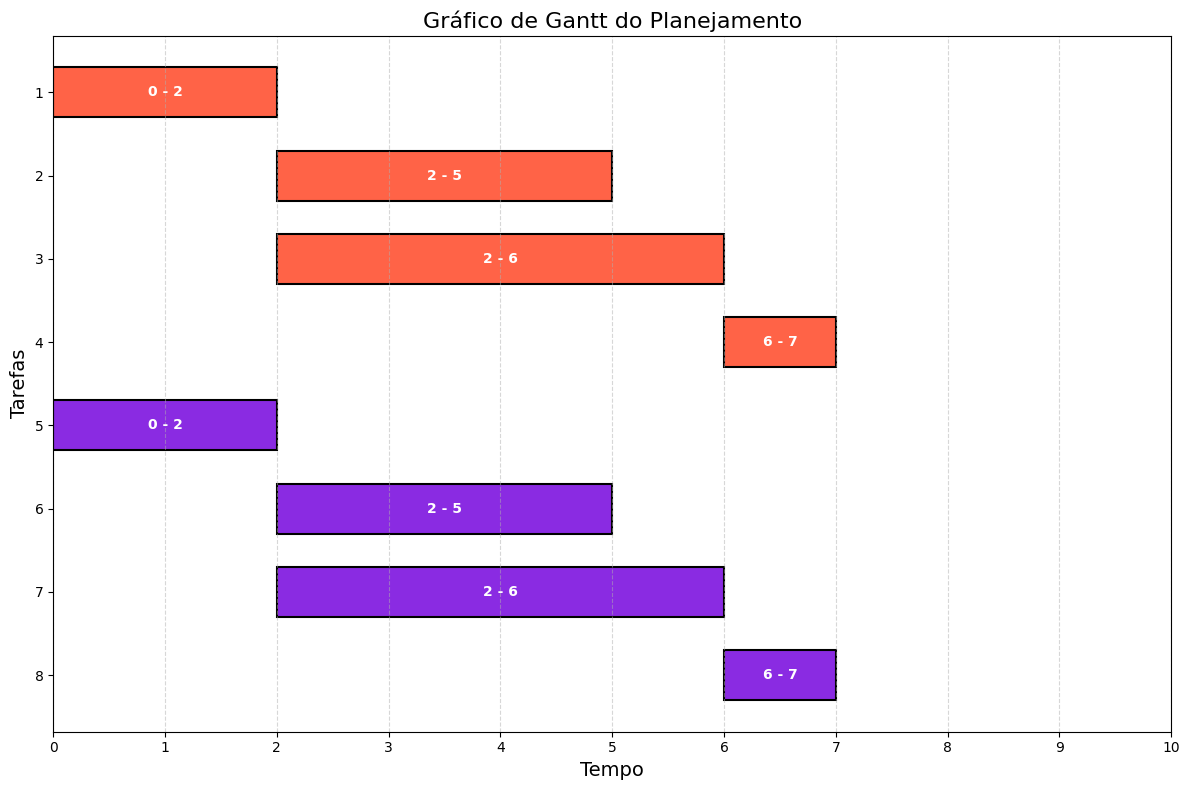

In [29]:
# Exemplo de execução
predecessores, duracao_recursos, recursos_disponiveis = carregar_dados('p01_dataset_8.txt')

# Criar o grafo de precedência
grafo = nx.DiGraph()
for tarefa, dependencias in predecessores.items():
    for dependente in dependencias:
        grafo.add_edge(tarefa, dependente)

# Rodar o CPM
tempos_inicio, tempos_fim, makespan = critical_path_method(predecessores, duracao_recursos)

# Verificar restrições de recursos
valido, conflito = validar_recursos(tempos_inicio, duracao_recursos, recursos_disponiveis)
if valido:
    print("Os recursos são válidos.")
else:
    print(f"Conflito de recursos no tempo {conflito}.")

# Rodar o algoritmo genético para otimização
best_solution, best_makespan = algoritmo_genetico(list(predecessores.keys()), duracao_recursos)
print("Melhor solução encontrada:", best_solution)
print("Makespan otimizado:", best_makespan)

# Plotar o gráfico de Gantt
plot_gantt(tempos_inicio, duracao_recursos, predecessores)


## Conclusão

Neste projeto, utilizamos **algoritmos de planejamento de tarefas** para otimizar a execução de um conjunto de tarefas interdependentes, levando em consideração tanto as **relações de precedência** quanto as **restrições de recursos**. As principais etapas realizadas foram:

1. **Carregamento e Processamento dos Dados:**
   - Importamos e processamos os dados das tarefas, suas durações, dependências e recursos disponíveis.

2. **Cálculo do Makespan:**
   - O *makespan*, ou tempo total necessário para completar o projeto, foi calculado utilizando o **Critical Path Method (CPM)**. Este cálculo considerou as dependências entre tarefas e seus tempos de execução.

3. **Validação de Recursos:**
   - Verificamos se os recursos disponíveis eram suficientes para alocar as tarefas de acordo com os tempos calculados, garantindo que não houvesse conflitos.

4. **Otimização com Algoritmo Genético:**
   - Implementamos um **algoritmo genético** para otimizar a ordem de execução das tarefas, visando reduzir o *makespan* e melhorar a alocação dos recursos.

5. **Visualização do Planejamento:**
   - Geramos um **gráfico de Gantt** para visualizar a execução das tarefas ao longo do tempo, facilitando o entendimento do cronograma de atividades.

6. **Exibição do Grafo de Dependências:**
   - Visualizamos o grafo de precedência das tarefas, ajudando a entender as relações entre as tarefas e suas dependências.

### Resultados:
- **Makespan Calculado:** O tempo total para a conclusão do projeto, levando em conta as dependências e a alocação de recursos.
- **Grafo de Dependências:** Um gráfico visualizando como as tarefas estão interligadas e suas ordens de execução.
- **Otimização com Algoritmo Genético:** Identificamos uma solução otimizada para a execução das tarefas, minimizando o *makespan*.



Este projeto demonstrou a importância da aplicação de **algoritmos de otimização** para o planejamento de tarefas em projetos, garantindo a melhor utilização dos recursos e o menor tempo de execução possível.
